In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
import spacy
import nltk
from nltk.corpus import stopwords
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score,precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, train_test_split
from transformers import pipeline
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification, AdamW
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments

nltk.download('stopwords')
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# !pip install transformers

In [ ]:
#This code is only required in case of google drive is being used

# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#This code is only required in case of google drive is being used

# import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [ ]:
doc = pd.read_csv('labeled_data.csv')

In [ ]:
doc.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
#remove the twitter handles/Usernames
clean = []
for text in doc['tweet']:
  clean_tweet = re.sub(r'@\w+', '', text)
  clean.append(clean_tweet)
doc['clean_text'] = clean

In [ ]:
#removing the special characters and numbers
doc['clean_text'] = doc['clean_text'].str.replace("[^a-zA-Z]", " ")

<ipython-input-9-b74ab42968d9>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  doc['clean_text'] = doc['clean_text'].str.replace("[^a-zA-Z]", " ")


In [ ]:
doc

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,clean_text
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT As a woman you shouldn t complain abo...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT boy dats cold tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT Dawg RT You ever fuck a bitc...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT The shit you hear about me ...
...,...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,you s a muthaf in lie right His ...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",you ve gone and broke the wrong heart baby an...
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,youu got wild bitches tellin you lies


In [ ]:
#removing all blank enteries
doc = doc[doc.clean_text!=" "]
doc = doc[doc.clean_text!=""]

In [ ]:
#using Spacy to remove all the spaces, punctuations and stopwords
#removing all the words that have a length less than 3
def text_cleanup(text):
  tokens = []
  doc = nlp(text)
  for t in doc:
    if not t.is_stop and not t.is_punct and not  t.is_space and len(t) > 3:
      tokens.append(t.lemma_.lower())
  return ' '.join(tokens)

In [ ]:
filtered = []
for d in doc['clean_text']:
    processed_text = text_cleanup(d)
    filtered.append(processed_text)

doc['clean_text'] = filtered

In [ ]:
#tokenization of the tweets
tokenized_text = doc['clean_text'].apply(lambda x: x.split())
tokenized_text
doc['tokens'] = tokenized_text

In [ ]:
#reducing the size if the dataset has more than 10000 enteries
if doc.shape[0] > 10000:
    doc = doc.sample(frac=0.4, replace=True, random_state=1)

In [ ]:
#creating a dictionary of the count of each word(count)
list1 =[]
for li in doc['tokens']:
    new = set(li)
    for words in new:
        list1.append(words)
count = Counter(list1)
count = dict(count)

In [ ]:
#giving each of the following words an ID(dict1)
list1 = []
dict1 = {}
for words in doc['tokens']:
     for word in words:
        list1.append(word)
set1 = set(list1)
count = 0
for words in set1:
    dict1[words] = count
    count = count + 1

In [ ]:
#making a dictionary of each word corresponding to id
vec = {}
list1 = []
for word in doc['tokens']:
    vec = {}
    counts = Counter(word)
    for t, c in counts.items():
        tf = 1 + math.log10(c) if c > 0 else 0
        idf = math.log10(9913 / counts[t])
        vec[dict1[t]] = tf * idf
    list1.append(vec)

In [ ]:
doc['tfidf'] = list1

### Test Train Split

In [ ]:
texts = doc['clean_text'].tolist()
labels = doc['class'].tolist()

In [ ]:
#number of documents under each label
from collections import Counter
Counter(labels)

Counter({1: 7696, 2: 1671, 0: 546})

In [ ]:
#splitting the data into 60/20/20
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
texts_train, texts_val, labels_train, labels_val = train_test_split(texts_train, labels_train, test_size=0.25, random_state=42)

In [ ]:
print(f"{len(texts_train)=}\t{len(labels_train)=}")
print(f"{len(texts_val)=}\t{len(labels_val)=}")
print(f"{len(texts_test)=}\t{len(labels_test)=}")

len(texts_train)=5947	len(labels_train)=5947
len(texts_val)=1983	len(labels_val)=1983
len(texts_test)=1983	len(labels_test)=1983


In [ ]:
total = len(texts_train) + len(texts_val) + len(texts_test)
len(texts_train)/total, len(texts_val)/total, len(texts_test)/total

(0.5999192978916574, 0.20004035105417128, 0.20004035105417128)

### Kmeans 

In [ ]:
# Creating a vectorizer of TFIDF
vectorizer = TfidfVectorizer()

In [ ]:
# Convert text data to a TF-IDF matrix
tfidf_matrix_train = vectorizer.fit_transform(texts_train)
tfidf_matrix_val = vectorizer.fit_transform(texts_val)

vectorizer = TfidfVectorizer(stop_words='english')
train_X = vectorizer.fit_transform(texts_train)
val_X = vectorizer.transform(texts_val)
test_X = vectorizer.transform(texts_test)

#the number of clusters for Kmeans
k = 5

In [ ]:
cluster_5 = []

In [ ]:
# Initializing the KMeans model 
kmeans_model = KMeans(n_clusters=k, random_state=42)

# Fitting the TFIDF matrix to the model
kmeans_model.fit(train_X)

# Get the predicted cluster assignments for the validation data
labels_pred = kmeans_model.predict(val_X)

labels_cm = [0,1,2]

confusion_mat = confusion_matrix(labels_val, labels_pred, labels = labels_cm)
print("Confusion Matrix:\n", confusion_mat)

# Getting the top words for each cluster
top_words_per_cluster = []
order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
terms = list(vectorizer.vocabulary_.keys())

for i in range(k):
    top_words = [terms[ind] for ind in order_centroids[i, :10]]
    top_words_per_cluster.append(top_words)
    cluster_5.append(top_words)
    print("Cluster ", i, " : ", top_words)
    
accuracy = accuracy_score(labels_val, labels_pred)
recall = recall_score(labels_val, labels_pred, average='macro')
f1 = f1_score(labels_val, labels_pred, average='macro')
precision = precision_score(labels_val, labels_pred, average='macro')

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 score:", round(f1,3))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Confusion Matrix:
 [[ 79  18   2]
 [996 162 156]
 [314  25   1]]
Cluster  0  :  ['unbelievable', 'ships', 'fitzgerald', 'derrick', 'couch', 'lowww', 'spfhbbkvd', 'comeback', 'xytlsf', 'dad']
Cluster  1  :  ['fucker', 'unbelievable', 'correspondent', 'derrick', 'ships', 'spfhbbkvd', 'couch', 'wayhustle', 'lbum', 'xrobdfztk']
Cluster  2  :  ['stereotype', 'fucker', 'ships', 'mentally', 'spfhbbkvd', 'derrick', 'utility', 'finesse', 'delight', 'nugga']
Cluster  3  :  ['disparagement', 'ships', 'solarte', 'finesse', 'derrick', 'xytlsf', 'lowww', 'couch', 'xrobdfztk', 'nugga']
Cluster  4  :  ['unbelievable', 'derrick', 'fucker', 'finna', 'import', 'spin', 'wayhustle', 'khsv', 'riding', 'fully']
Accuracy: 0.122
Precision: 0.171
Recall: 0.169
F1 score: 0.059


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for j in range(5):
    print("documents in cluster ",  j)
    cluster_indices = np.where(labels_pred == i)[0]
    for j in range(min(5, len(cluster_indices))):
        print(doc['clean_text'].iloc[cluster_indices[j]])
    print('\n')

documents in cluster  0
hillary dodo bird dems candidate obama prez http wflzyxmvk
tongue kiss bitch
twig bitch like
girl go school kind aquatic colored weave head fuck go
niggas outfit impress bitch


documents in cluster  1
hillary dodo bird dems candidate obama prez http wflzyxmvk
tongue kiss bitch
twig bitch like
girl go school kind aquatic colored weave head fuck go
niggas outfit impress bitch


documents in cluster  2
hillary dodo bird dems candidate obama prez http wflzyxmvk
tongue kiss bitch
twig bitch like
girl go school kind aquatic colored weave head fuck go
niggas outfit impress bitch


documents in cluster  3
hillary dodo bird dems candidate obama prez http wflzyxmvk
tongue kiss bitch
twig bitch like
girl go school kind aquatic colored weave head fuck go
niggas outfit impress bitch


documents in cluster  4
hillary dodo bird dems candidate obama prez http wflzyxmvk
tongue kiss bitch
twig bitch like
girl go school kind aquatic colored weave head fuck go
niggas outfit impres

## Classifiers

In [ ]:
#creating dataset to stor performance metrics in
values = pd.DataFrame(columns=['Classifiers', 'Accuracy', 'Precision', 'Recall', 'F1', 'Average'])
log = pd.DataFrame(columns = ['Classifiers', 'Accuracy', 'Precision', 'Recall', 'F1'])

### Dummy Classifier using "most_frequent"

In [ ]:
# create a dummy classifier with strategy="most_frequent"
most_freq = DummyClassifier(strategy="most_frequent")

# train the classifier
most_freq.fit(texts_train, labels_train)

# Make predictions on the validation data
labels_pred = most_freq.predict(texts_val)

accuracy = accuracy_score(labels_val, labels_pred)
recall = recall_score(labels_val, labels_pred, average='macro')
f1 = f1_score(labels_val, labels_pred, average='macro')
precision = precision_score(labels_val, labels_pred, average='macro')

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 score:", round(f1,3))

# Calculating the label distribution
label_distribution_1 = pd.Series(labels_pred).value_counts()

values.loc[0] = ["Dummy Classifier using most_frequent", round(accuracy,3), round(precision,3), round(recall,3), round(f1,3), " "]

Accuracy: 0.775
Precision: 0.258
Recall: 0.333
F1 score: 0.291


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Dummy Classifier using "Stratified"

In [ ]:
# create a dummy classifier with strategy="most_frequent"
strat = DummyClassifier(strategy="stratified")

# train the dummy classifier
strat.fit(texts_train, labels_train)

# Making predictions on the validation data
labels_pred = strat.predict(texts_val)

accuracy = accuracy_score(labels_val, labels_pred)
recall = recall_score(labels_val, labels_pred, average='macro')
f1 = f1_score(labels_val, labels_pred, average='macro')
precision = precision_score(labels_val, labels_pred, average='macro')

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 score:", round(f1,3))

# Calculating the label distribution
label_distribution_2 = pd.Series(labels_pred).value_counts()

values.loc[1] = ["Dummy Classifier using stratified", round(accuracy,3), round(precision,3), round(recall,3), round(f1,3), " "]

Accuracy: 0.639
Precision: 0.338
Recall: 0.338
F1 score: 0.338


### Logistic Regression using one hot vectorization

In [ ]:
# Create a CountVectorizer object
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1,2))

# Fit the vectorizer on the training data and transform the training and validation data
train_one_hot = vectorizer.fit_transform(texts_train)
test_one_hot = vectorizer.transform(texts_val)
train_one_hot_2= train_one_hot.toarray()
test_one_hot_2 = test_one_hot.toarray()


# Create an OneHotEncoder object and fit it on the one-hot vectors of the training set
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(train_one_hot_2)

# Transform the one-hot vectors of both the training and testing sets into one-hot encoded vectors
train_one_hot_encoded = encoder.transform(train_one_hot_2)
test_one_hot_encoded = encoder.transform(test_one_hot_2)

In [ ]:
logistic = LogisticRegression()
logistic.fit(train_one_hot_encoded, labels_train)

# Make predictions on validation data
preds = logistic.predict(test_one_hot_encoded)

# Calculate accuracy, recall, and F1 score
acc = accuracy_score(labels_val, preds)
recall = recall_score(labels_val, preds, average='macro')
f1 = f1_score(labels_val, preds, average='macro')
precision = precision_score(labels_val, preds, average='macro')

print("Accuracy:", round(acc, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 score:", round(f1,3))

# Calculating the label distribution
label_distribution_3 = pd.Series(preds).value_counts()

values.loc[2] = ["Logistic Regression: using one hot", round(acc,3), round(precision,3), round(recall,3), round(f1,3), " "]

Accuracy: 0.887
Precision: 0.748
Recall: 0.671
F1 score: 0.698


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Logistic Regession using TFIDF vectorisation

In [ ]:
# Create a TfidfVectorizer object and fit it on the training set
vectorizer = TfidfVectorizer()
vectorizer.fit(texts_train)

# vectorizing the tweets in both the training and validation data 
train_tfidf = vectorizer.transform(texts_train)
test_tfidf = vectorizer.transform(texts_val)

In [ ]:
logistic = LogisticRegression()
logistic.fit(train_tfidf, labels_train)

# Make predictions on the validation data
preds = logistic.predict(test_tfidf)

# Calculate accuracy, recall, and F1 score
acc = accuracy_score(labels_val, preds)
recall = recall_score(labels_val, preds, average='macro')
f1 = f1_score(labels_val, preds, average='macro')
precision = precision_score(labels_val, preds, average='macro')

print("Accuracy:", round(acc, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 score:", round(f1,3))

# Calculating the label distribution
label_distribution_4 = pd.Series(preds).value_counts()

values.loc[3] = ["Logistic Regression using tfidf", round(acc,3), round(precision,3), round(recall,3), round(f1,3), " "]
log.loc[0] = ["Logistic Regression using tfidf", round(acc,3), round(precision,3), round(recall,3), round(f1,3)]

Accuracy: 0.891
Precision: 0.819
Recall: 0.626
F1 score: 0.671


### SVC Classifier with One-hot vectorization

In [ ]:
# Create a CountVectorizer object and fit it on the training set
vectorizer = CountVectorizer()
vectorizer.fit(texts_train)

# Transform the tweets in both the training and testing sets into one-hot vectors
train_one_hot = vectorizer.transform(texts_train)
test_one_hot = vectorizer.transform(texts_val)
train_one_hot_2= train_one_hot.toarray()
test_one_hot_2 = test_one_hot.toarray()


# Create an OneHotEncoder object and fit it on the one-hot vectors of the training set
encoder1 = OneHotEncoder(handle_unknown='ignore')
encoder1.fit(train_one_hot_2)

# Transform the one-hot vectors of both the training and testing sets into one-hot encoded vectors
train_one_hot_encoded = encoder1.transform(train_one_hot_2)
test_one_hot_encoded = encoder1.transform(test_one_hot_2)

In [ ]:
# Create an SVC object and fit it on the training data
svc = SVC()
svc.fit(train_one_hot_encoded, labels_train)

# Make predictions on the validation data
preds = svc.predict(test_one_hot_encoded)

# Calculate accuracy, recall, and F1 score
acc = accuracy_score(labels_val, preds)
recall = recall_score(labels_val, preds, average='macro')
f1 = f1_score(labels_val, preds, average='macro')
precision = precision_score(labels_val, preds, average='macro')

print("Accuracy:", round(acc, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 score:", round(f1,3))

# Calculating the label distribution
label_distribution_5 = pd.Series(preds).value_counts()

values.loc[4] = ["SVC using one hot", round(acc,3), round(precision,3), round(recall,3), round(f1,3), " "]

Accuracy: 0.775
Precision: 0.258
Recall: 0.333
F1 score: 0.291


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Table and F1 bar graph

In [ ]:
#print original validation data and classifier predicted label distribution
from collections import Counter
print("Original count", Counter(labels_val))
print("Dummy Classifier with most frequent \n", label_distribution_1)
print("Dummy Classifier with Stratified \n", label_distribution_2)
print("Logistic regression using one hot \n", label_distribution_3)
print("Logistic regression using TFIDF \n", label_distribution_4)
print("SVC using one hot \n", label_distribution_5)

Original count Counter({1: 1536, 2: 340, 0: 107})
Dummy Classifier with most frequent 
 1    1983
dtype: int64
Dummy Classifier with Stratified 
 1    1523
2     348
0     112
dtype: int64
Logistic regression using one hot 
 1    1604
2     319
0      60
dtype: int64
Logistic regression using TFIDF 
 1    1676
2     279
0      28
dtype: int64
SVC using one hot 
 1    1983
dtype: int64


In [ ]:
#tabel comparing all the classifiers
values

,Classifiers,Accuracy,Precision,Recall,F1,Average
0,Dummy Classifier using most_frequent,0.775,0.258,0.333,0.291,
1,Dummy Classifier using stratified,0.639,0.338,0.338,0.338,
2,Logistic Regression: using one hot,0.887,0.748,0.671,0.698,
3,Logistic Regression using tfidf,0.891,0.819,0.626,0.671,
4,SVC using one hot,0.775,0.258,0.333,0.291,


([0, 1, 2, 3, 4],
 [Text(0, 0, 'Dummy Classifier using most_frequent'),
  Text(1, 0, 'Dummy Classifier using stratified'),
  Text(2, 0, 'Logistic Regression: using one hot'),
  Text(3, 0, 'Logistic Regression using tfidf'),
  Text(4, 0, 'SVC using one hot')])

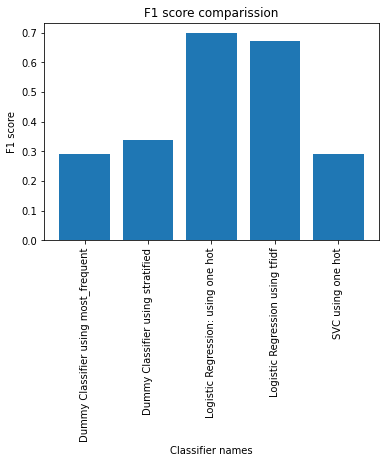

In [ ]:
#creating a bar graph for the F1 score of the classifiers
names = values['Classifiers'].tolist()
f1score = values['F1'].tolist()

# Create a bar chart
plt.bar(names, f1score)

# Add labels and title to x-axis and y-axis
plt.xlabel('Classifier names')
plt.ylabel('F1 score')
plt.title('F1 score comparission')
plt.xticks(rotation=90)

In [ ]:
plt.show()

### Best Classifier in terms of Accuracy, Precision, Recall and F1

In [ ]:
Acc = values['Accuracy'].tolist()
pre = values['Precision'].tolist()
rec = values['Recall'].tolist()

for i in range(len(Acc)):
    overall = Acc[i] + pre[i] + rec[i] + f1score[i]
    #values['Average'].loc(i) = overall
    values.loc[i, 'Average'] = overall

values
maxi = values['Average'].max()
name = values.loc[values['Average'] == maxi]

print("The best classifier with respect to accuracy, precision, recall and f1 score is: ", name['Classifiers'].values[0])

The best classifier with respect to accuracy, precision, recall and f1 score is:  Logistic Regression using tfidf


### Decision Tree using CountVectorizer

In [ ]:
#vectorizing the training and validation data using CountVectorizer
vectorizer = CountVectorizer()
texts_train_vec = vectorizer.fit_transform(texts_train)
texts_test_vec = vectorizer.transform(texts_val)

# Train a Decision Tree classifier on the training data
clf = DecisionTreeClassifier()
clf.fit(texts_train_vec, labels_train)

# Predict the labels of the validation data
labels_pred = clf.predict(texts_test_vec)

# Calculate the accuracy, recall, and F1-score of the model
accuracy = accuracy_score(labels_val, labels_pred)
recall = recall_score(labels_val, labels_pred, average='macro')
f1 = f1_score(labels_val, labels_pred, average='macro')
precision = precision_score(labels_val, labels_pred, average='macro')

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 score:", round(f1,3))

av = accuracy + precision + recall + f1

# Calculating the label distribution
label_distribution_6 = pd.Series(labels_pred).value_counts()

print("Decision Tree: \n", label_distribution_6)
print("Original count", Counter(labels_val))


values.loc[5] = ["Decision Tree using CountVectorizer", round(accuracy,3), round(precision,3), round(recall,3), round(f1,3), round(av,3)]

Accuracy: 0.885
Precision: 0.731
Recall: 0.737
F1 score: 0.734
Decision Tree: 
 1    1530
2     343
0     110
dtype: int64
Original count Counter({1: 1536, 2: 340, 0: 107})


In [ ]:
values

,Classifiers,Accuracy,Precision,Recall,F1,Average
0,Dummy Classifier using most_frequent,0.775,0.258,0.333,0.291,1.657
1,Dummy Classifier using stratified,0.639,0.338,0.338,0.338,1.653
2,Logistic Regression: using one hot,0.887,0.748,0.671,0.698,3.004
3,Logistic Regression using tfidf,0.891,0.819,0.626,0.671,3.007
4,SVC using one hot,0.775,0.258,0.333,0.291,1.657
5,Decision Tree using CountVectorizer,0.885,0.731,0.737,0.734,3.087


### Logistic Regression with Parameter Tuning


In [ ]:
#creating a pipeline for vectorizer and logistic regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

#setting all the possible values of the parameters
parameters = {
    'tfidf__sublinear_tf': [True, False],
    'tfidf__max_features': [None, 10000, 20000, 30000, 40000, 50000],
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'clf__max_iter': [500, 1000, 1500]
}

#running a grid search to find the best parameters
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(texts_train, labels_train)

# Get the best estimator
best_estimator = grid_search.best_estimator_

# Make predictions on the validation data
labels_pred = best_estimator.predict(texts_val)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


In [ ]:
accuracy = accuracy_score(labels_val, labels_pred)
recall = recall_score(labels_val, labels_pred, average='macro')
f1 = f1_score(labels_val, labels_pred, average='macro')
precision = precision_score(labels_val, labels_pred, average='macro')

print("Best hyperparameters: ", grid_search.best_params_)
print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 score:", round(f1,3))

log.loc[1] = ["Tuned Logistic Regression using tfidf", round(accuracy,3), round(precision,3), round(recall,3), round(f1,3)]

Best hyperparameters:  {'clf__C': 10, 'clf__max_iter': 500, 'tfidf__max_features': None, 'tfidf__sublinear_tf': False}
Accuracy: 0.894
Precision: 0.788
Recall: 0.709
F1 score: 0.741


In [ ]:
#comparison of before and after parameter tuning
log

,Classifiers,Accuracy,Precision,Recall,F1
0,Logistic Regression using tfidf,0.891,0.819,0.626,0.671
1,Tuned Logistic Regression using tfidf,0.894,0.788,0.709,0.741


### Context vectors using BERT

In [ ]:
#checking if GPU is in use
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU


In [ ]:
#a dataset to store and compare all the classifiers using BERT
values1 = pd.DataFrame(columns=['Classifiers', 'Accuracy', 'Precision', 'Recall', 'F1', 'Average'])

In [ ]:
import transformers

nlp_features = transformers.pipeline('feature-extraction', model="roberta-base")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Using the feature extractio to encode the tweets in the documents
X_train_encoded = nlp_features(texts_train, padding=True, truncation=True, max_length=512)

# Extracting the first context vector for each tweet
X_train_encoded = [x[0][0] for x in X_train_encoded]

In [ ]:
#creating an object and fitting the training data through Logistic Regression
logistic = LogisticRegression()
logistic.fit(X_train_encoded, labels_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Using the feature extraction to encode the tweets in the validation data
X_val_encoded = nlp_features(texts_val, padding=True, truncation=True, max_length=512)

# Extracting the first context vector for each tweet
X_val_encoded = [x[0][0] for x in X_val_encoded]

In [ ]:
y_val_pred = logistic.predict(X_val_encoded)

# Calculate the accuracy, precision, recall, and F1 
accuracy = accuracy_score(labels_val, y_val_pred)
precision = precision_score(labels_val, y_val_pred, average="macro")
recall = recall_score(labels_val, y_val_pred, average="macro")
f1 = f1_score(labels_val, y_val_pred, average="macro")

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 score:", round(f1,3))

sum = accuracy + precision + recall + f1
values1.loc[0] = ["Feature Extraction with Bert", round(accuracy,3), round(precision,3), round(recall,3), round(f1,3), round(sum, 3)]

Accuracy: 0.85
Precision: 0.714
Recall: 0.525
F1 score: 0.55


End To End Classifier

In [ ]:
#tokenizer for roberta base
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

In [ ]:
def tokenize_data(text, label):
    encoding = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    return {
        'input_ids': encoding['input_ids'].squeeze(),
        'attention_mask': encoding['attention_mask'].squeeze(),
        'label': torch.tensor(label)
    }

In [ ]:
#creating a custom class for converting into the dataset
#code inspiration taking from the HuggingFace documentation
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return tokenize_data(self.texts[idx], self.labels[idx])

In [ ]:
#Encoding and tokenizing the data
train_dataset = TextDataset(texts_train, labels_train)
val_dataset = TextDataset(texts_val, labels_val)
test_dataset = TextDataset(texts_test, labels_test)

In [ ]:
#model of roberta base
num_classes = len(set(labels_train))
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_classes)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0,
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda pred: {'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1)), 
                                  'precision_recall_fscore_support': precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='macro')},
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Recall Fscore Support
1,No log,0.290836,0.900656,"(0.7343256638365819, 0.6770107010872884, 0.6834415746674977, None)"


Trainer is attempting to log a value of "(0.7343256638365819, 0.6770107010872884, 0.6834415746674977, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=372, training_loss=0.4254014620216944, metrics={'train_runtime': 202.4954, 'train_samples_per_second': 29.369, 'train_steps_per_second': 1.837, 'total_flos': 391183873807104.0, 'train_loss': 0.4254014620216944, 'epoch': 1.0})

In [ ]:
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
val_labels = val_dataset.labels
accuracy = accuracy_score(val_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(val_labels, predicted_labels, average='macro')

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 score:", round(f1,3))

sum = accuracy + precision + recall + f1
values1.loc[1] = ["1e-4, 16, 1", round(accuracy,3), round(precision,3), round(recall,3), round(f1,3), round(sum, 3)]

Accuracy: 0.901
Precision: 0.734
Recall: 0.677
F1 score: 0.683


Changing the Parameters

Learning rate: 2e-5, Batch size: 32,64 and Epochs = 3

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0,
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda pred: {'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1)), 
                                  'precision_recall_fscore_support': precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='macro')},
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Recall Fscore Support
1,No log,0.279736,0.902673,"(0.7416941209486323, 0.7260751194948384, 0.7323933659253367, None)"
2,No log,0.282720,0.905194,"(0.7536693271119091, 0.7366183199331134, 0.7439151588377833, None)"
3,0.251800,0.295017,0.902168,"(0.7492274781475343, 0.7293644726192658, 0.7379634781369009, None)"


Trainer is attempting to log a value of "(0.7416941209486323, 0.7260751194948384, 0.7323933659253367, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "(0.7536693271119091, 0.7366183199331134, 0.7439151588377833, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "(0.7492274781475343, 0.7293644726192658, 0.7379634781369009, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=558, training_loss=0.24777300981637826, metrics={'train_runtime': 493.3699, 'train_samples_per_second': 36.162, 'train_steps_per_second': 1.131, 'total_flos': 1173551621421312.0, 'train_loss': 0.24777300981637826, 'epoch': 3.0})

In [ ]:
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
val_labels = val_dataset.labels
accuracy = accuracy_score(val_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(val_labels, predicted_labels, average='macro')

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 score:", round(f1,3))

sum = accuracy + precision + recall + f1
values1.loc[2] = ["2e-5, 32, 64, 3", round(accuracy,3), round(precision,3), round(recall,3), round(f1,3), round(sum, 3)]

Accuracy: 0.905
Precision: 0.754
Recall: 0.737
F1 score: 0.744


Learning rate: 3e-5, Batch size: 32,64 and Epochs = 3

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0,
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda pred: {'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1)), 
                                  'precision_recall_fscore_support': precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='macro')},
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Recall Fscore Support
1,No log,0.404388,0.889057,"(0.736978288446201, 0.6962404938610959, 0.7148706994599122, None)"
2,No log,0.343948,0.910741,"(0.770245070340254, 0.7441938584234317, 0.7541406826508109, None)"
3,0.171200,0.350857,0.901160,"(0.7411679996304031, 0.7132100255405901, 0.7259692906454095, None)"


Trainer is attempting to log a value of "(0.736978288446201, 0.6962404938610959, 0.7148706994599122, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "(0.770245070340254, 0.7441938584234317, 0.7541406826508109, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "(0.7411679996304031, 0.7132100255405901, 0.7259692906454095, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=558, training_loss=0.17092586845479985, metrics={'train_runtime': 423.5004, 'train_samples_per_second': 42.127, 'train_steps_per_second': 1.318, 'total_flos': 1173551621421312.0, 'train_loss': 0.17092586845479985, 'epoch': 3.0})

In [ ]:
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
val_labels = val_dataset.labels
accuracy = accuracy_score(val_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(val_labels, predicted_labels, average='macro')

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 score:", round(f1,3))

sum = accuracy + precision + recall + f1
values1.loc[3] = ["3e-5, 32, 64, 3", round(accuracy,3), round(precision,3), round(recall,3), round(f1,3), round(sum, 3)]

Accuracy: 0.911
Precision: 0.77
Recall: 0.744
F1 score: 0.754


Learning rate: 3e-5, Batch size: 16,16 and Epochs = 5

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0,
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda pred: {'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1)), 
                                  'precision_recall_fscore_support': precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='macro')},
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Recall Fscore Support
1,No log,0.579292,0.891074,"(0.7606671840514011, 0.6789427331485554, 0.7132033320912797, None)"
2,0.195300,0.376549,0.901160,"(0.752316051140431, 0.769040171072323, 0.7591392228622835, None)"
3,0.176800,0.421368,0.908724,"(0.7683628025091439, 0.6899281217549325, 0.7153655578191936, None)"
4,0.176800,0.463356,0.909733,"(0.7718142357920349, 0.7492458081363388, 0.7595018062556685, None)"
5,0.136400,0.520550,0.901160,"(0.7501600139163024, 0.7423477967900557, 0.746157006568218, None)"


Trainer is attempting to log a value of "(0.7606671840514011, 0.6789427331485554, 0.7132033320912797, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "(0.752316051140431, 0.769040171072323, 0.7591392228622835, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "(0.7683628025091439, 0.6899281217549325, 0.7153655578191936, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "(0.7718142357920349, 0.7492458081363388, 0.7595018062556685, None)" of type <class 'tuple'> fo

TrainOutput(global_step=1860, training_loss=0.15587476299655054, metrics={'train_runtime': 898.9275, 'train_samples_per_second': 33.078, 'train_steps_per_second': 2.069, 'total_flos': 1955919369035520.0, 'train_loss': 0.15587476299655054, 'epoch': 5.0})

In [ ]:
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
val_labels = val_dataset.labels
accuracy = accuracy_score(val_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(val_labels, predicted_labels, average='macro')

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 score:", round(f1,3))

sum = accuracy + precision + recall + f1
values1.loc[4] = ["3e-5, 16, 5", round(accuracy,3), round(precision,3), round(recall,3), round(f1,3), round(sum, 3)]

Accuracy: 0.91
Precision: 0.772
Recall: 0.749
F1 score: 0.76


In [ ]:
values1

,Classifiers,Accuracy,Precision,Recall,F1,Average
0,Feature Extraction with Bert,0.850,0.714,0.525,0.550,2.639
1,"1e-4, 16, 1",0.901,0.734,0.677,0.683,2.995
2,"2e-5, 32, 64, 3",0.905,0.754,0.737,0.744,3.139
3,"3e-5, 32, 64, 3",0.911,0.770,0.744,0.754,3.179
4,"3e-5, 16, 5",0.910,0.772,0.749,0.760,3.190


Best Classifier on test dataset

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0,
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda pred: {'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1)), 
                                  'precision_recall_fscore_support': precision_recall_fscore_support(pred.label_ids, pred.predictions.argmax(-1), average='macro')},
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Recall Fscore Support
1,No log,0.433769,0.911750,"(0.7708691126723913, 0.7345248231499224, 0.751037851037851, None)"
2,No log,0.441772,0.919818,"(0.7961994230841768, 0.7556135301333291, 0.7730372405195931, None)"
3,0.077100,0.481692,0.916793,"(0.7747646719477705, 0.7686861916635266, 0.7712770076731544, None)"


Trainer is attempting to log a value of "(0.7708691126723913, 0.7345248231499224, 0.751037851037851, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "(0.7961994230841768, 0.7556135301333291, 0.7730372405195931, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "(0.7747646719477705, 0.7686861916635266, 0.7712770076731544, None)" of type <class 'tuple'> for key "eval/precision_recall_fscore_support" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=558, training_loss=0.07658602687193074, metrics={'train_runtime': 424.0064, 'train_samples_per_second': 42.077, 'train_steps_per_second': 1.316, 'total_flos': 1173551621421312.0, 'train_loss': 0.07658602687193074, 'epoch': 3.0})

In [ ]:
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
test_labels = test_dataset.labels
accuracy = accuracy_score(test_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='macro')

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 score:", round(f1,3))

sum = accuracy + precision + recall + f1
values1.loc[5] = ["3e-5, 32,64, 3 on test", round(accuracy,3), round(precision,3), round(recall,3), round(f1,3), round(sum, 3)]

Accuracy: 0.92
Precision: 0.796
Recall: 0.756
F1 score: 0.773


In [ ]:
#confusion matrix for the best model
labels_pred =  np.argmax(predictions.predictions, axis=-1)

labels_cm = [0,1,2]

confusion_mat = confusion_matrix(test_labels, labels_pred, labels = labels_cm)
print("Confusion Matrix:\n", confusion_mat)

Confusion Matrix:
 [[  44   47    9]
 [  28 1504   32]
 [   5   38  276]]
